# LuxonisDatasetFormat - testing embeddings methods

In [5]:
import os
import uuid

import numpy as np
import onnx
import onnxruntime
import torch
import torch.onnx
import torchvision
from matplotlib import pyplot as plt
from utils.data_utils import load_mnist_data

from luxonis_ml.data import (
    LuxonisDataset,
    LuxonisLoader,
)
from luxonis_ml.utils import LuxonisFileSystem
from luxonis_ml.embeddings.utils.embedding import (
    extract_embeddings,
    extract_embeddings_onnx,
    extract_embeddings_onnx_LFS,
    load_embeddings,
    save_embeddings,
)
from luxonis_ml.embeddings.utils.ldf import generate_embeddings
from luxonis_ml.embeddings.utils.model import (
    export_model_onnx,
    extend_output_onnx,
    load_model,
    load_model_onnx,
    load_model_resnet50_minuslastlayer,
)
from luxonis_ml.embeddings.utils.qdrant import QdrantAPI, QdrantManager

## Pytorch examples

In [6]:
# Load the data
data_loader = load_mnist_data(save_path="./data/mnist", num_samples=640, batch_size=64)

100%|██████████| 9912422/9912422 [00:01<00:00, 7442041.89it/s]


Extracting ./data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./data/mnist/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 16121332.69it/s]


Extracting ./data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/mnist/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 6582281.62it/s]


Extracting ./data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/mnist/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 11226003.99it/s]

Extracting ./data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/mnist/MNIST/raw



In [7]:
# Load the model
model = load_model_resnet50_minuslastlayer()

In [8]:
# Extract embeddings from the dataset
embeddings, labels = extract_embeddings(model, data_loader)

In [9]:
save_embeddings(embeddings, labels, "./data/")

## ONNX models and Qdrant

In [10]:
# Load the data
data_loader = load_mnist_data(save_path="./data/mnist", num_samples=640, batch_size=64)

In [11]:
# Load the model
model = load_model()

# Export the model to ONNX
export_model_onnx(model, model_path_out="./data/resnet50.onnx")

# Load the ONNX model
onnx_model = load_model_onnx(model_path="./data/resnet50.onnx")

# Extend the ONNX model with an intermediate output layer
onnx_model = extend_output_onnx(
    onnx_model, intermediate_tensor_name="/Flatten_output_0"
)

# Save the ONNX model
onnx.save(onnx_model, "./data/resnet50-1.onnx")

In [12]:
# Create an ONNX Runtime session
provider = (
    ["CUDAExecutionProvider"]
    if torch.cuda.is_available()
    and "CUDAExecutionProvider" in onnxruntime.get_available_providers()
    else None
)
ort_session = onnxruntime.InferenceSession("./data/resnet50-1.onnx", providers=provider)

# Extract embeddings from the dataset
embeddings, labels = extract_embeddings_onnx(
    ort_session, data_loader, "/Flatten_output_0"
)

# Save the embeddings and labels to a file
save_embeddings(embeddings, labels, "./data/")

2024-02-01 10:31:47.210633074 [E:onnxruntime:Default, provider_bridge_ort.cc:1480 TryGetProviderInfo_CUDA] /onnxruntime_src/onnxruntime/core/session/provider_bridge_ort.cc:1193 onnxruntime::Provider& onnxruntime::ProviderLibrary::Get() [ONNXRuntimeError] : 1 : FAIL : Failed to load library libonnxruntime_providers_cuda.so with error: libcublasLt.so.11: cannot open shared object file: No such file or directory

2024-02-01 10:31:47.210668259 [W:onnxruntime:Default, onnxruntime_pybind_state.cc:747 CreateExecutionProviderInstance] Failed to create CUDAExecutionProvider. Please reference https://onnxruntime.ai/docs/execution-providers/CUDA-ExecutionProvider.html#requirements to ensure all dependencies are met.


In [13]:
embeddings, labels = load_embeddings("./data/")

In [14]:
# Start Qdrant docker container
QdrantManager("qdrant/qdrant", "qdrant_container").start_docker_qdrant()

Container is already running.


In [15]:
# Connect to Qdrant
qdrant_api = QdrantAPI("localhost", 6333, "Mnist")

In [16]:
# Create a collection
vector_size = embeddings.shape[1]
qdrant_api.create_collection(vector_size=vector_size, distance="cosine")

Created new collection


In [17]:
# Insert the embeddings into the collection
ids = [str(uuid.uuid5(uuid.NAMESPACE_DNS, str(e))) for e in embeddings]
qdrant_api.insert_embeddings(ids, embeddings.tolist(), labels.tolist(), batch_size=50)

In [18]:
# Search for the nearest neighbors
ids, scores = qdrant_api.search_similar_embeddings(embeddings[0], top_k=5)
labels = qdrant_api.retrieve_labels_by_ids(ids)

for i, (id, score, label) in enumerate(zip(ids, scores, labels)):
    print(f"ID: {id}, Score: {score}, Label: {label}")

ID: ff26d956-f460-5aa5-890e-24b2b0feffce, Score: 1.0000001, Label: 7
ID: 44b2f6c1-9c7a-501c-b642-13f3f7641bea, Score: 0.9608064, Label: 7
ID: 5e3e4422-5b9b-5391-a96e-a7ab2a0ba97f, Score: 0.9564658, Label: 7
ID: eb848059-cd0b-53a8-b1ec-9d9610b89146, Score: 0.9543483, Label: 7
ID: 68957035-1d64-5a15-89fe-fb4d41516c24, Score: 0.9535233, Label: 7


## LuxonisDatasetFormat, ONNX and Qdrant

In [19]:
NUM_SAMPLES = 6400  # -1 # minus one is equivalent to all samples
BATCH_SIZE = 64

In [20]:
# Load the MNIST data
data_loader = load_mnist_data(
    save_path="./data/mnist", num_samples=NUM_SAMPLES, batch_size=BATCH_SIZE
)
NUM_SAMPLES = len(data_loader.dataset)
print(f"Number of samples: {NUM_SAMPLES}")

Number of samples: 6400


In [21]:
# Create a tmp directory to store the images
mnist_image_dir = "./data/mnist_images"
if not os.path.exists(mnist_image_dir):
    os.makedirs(mnist_image_dir)

In [22]:
# Convert MNIST data to Luxonis ML format
def mnist_LDF_generator():
    batch_num = 0
    for batch in data_loader:
        images, labels = batch
        for i, (image, label) in enumerate(zip(images, labels)):
            # img_ix = batch_num * BATCH_SIZE + i

            # Save image to disk
            image_path = os.path.join(mnist_image_dir, f"{uuid.uuid4()}.jpg")
            # image_path = os.path.join(mnist_image_dir, f"mnist_{img_ix}.jpg")
            torchvision.utils.save_image(image, image_path)

            # Create dictionary structure for Luxonis ML
            yield {
                "file": image_path,
                "class": str(label.item()),
                "type": "classification",
                "value": True,
            }
        batch_num += 1


In [23]:
# 2. Load the MNIST Data into LDF
dataset_name = "Mnist_LDF"

# Create a new dataset in LDF
dataset = LuxonisDataset(dataset_name)

In [24]:
# Add the MNIST data to the dataset
dataset.set_classes(["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"])
dataset.add(mnist_LDF_generator)
dataset.make_splits()

100%|██████████| 6400/6400 [00:00<00:00, 21336.81it/s]


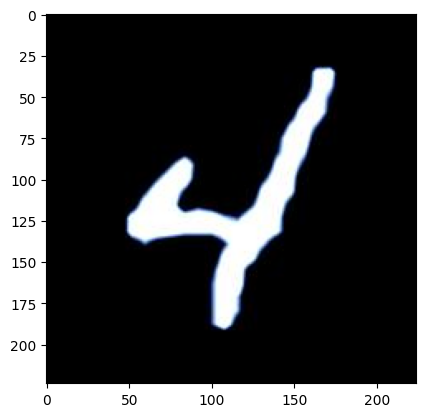

In [25]:
loader = LuxonisLoader(dataset)
for img, _ in loader:
    plt.imshow(img)
    plt.show()
    break

In [26]:
# Initialize the ONNX Runtime session for the model
provider = (
    ["CUDAExecutionProvider"]
    if torch.cuda.is_available()
    and "CUDAExecutionProvider" in onnxruntime.get_available_providers()
    else None
)
ort_session = onnxruntime.InferenceSession("./data/resnet50-1.onnx", providers=provider)

2024-02-01 10:32:14.319917828 [E:onnxruntime:Default, provider_bridge_ort.cc:1480 TryGetProviderInfo_CUDA] /onnxruntime_src/onnxruntime/core/session/provider_bridge_ort.cc:1193 onnxruntime::Provider& onnxruntime::ProviderLibrary::Get() [ONNXRuntimeError] : 1 : FAIL : Failed to load library libonnxruntime_providers_cuda.so with error: libcublasLt.so.11: cannot open shared object file: No such file or directory

2024-02-01 10:32:14.319934298 [W:onnxruntime:Default, onnxruntime_pybind_state.cc:747 CreateExecutionProviderInstance] Failed to create CUDAExecutionProvider. Please reference https://onnxruntime.ai/docs/execution-providers/CUDA-ExecutionProvider.html#requirements to ensure all dependencies are met.


In [27]:
# Start Qdrant docker container
QdrantManager("qdrant/qdrant", "qdrant_container").start_docker_qdrant()

# Connect to Qdrant
qdrant_api = QdrantAPI("localhost", 6333, "Mnist_LFS")

# Create a collection
qdrant_api.create_collection(vector_size=2048, distance="cosine")

Container is already running.
Created new collection


In [28]:
# Load the LuxonisDataset
emb_dict = generate_embeddings(
    dataset, ort_session, qdrant_api, output_layer_name="/Flatten_output_0"
)

Upserted 6400 of embeddings to VectorDB.
Embeddings generation and insertion completed!


In [29]:
first_emb = None

# get a specific sample from dataset
first_sample = list(emb_dict.keys())[0]
first_emb = emb_dict[first_sample]
sample_id = first_sample

df = dataset._load_df_offline()
sample = df[df["file"] == sample_id+".jpg"]
sample

,file,class,type,value,instance_id,value_type,created_at
0,e73ca79d-4541-413b-9c17-9dbb108d5680.jpg,5,classification,True,eba602ad-e002-58f6-a21c-1c67690c66a0,bool,2024-02-01 09:32:13.668798


In [30]:
# Search for the nearest neighbors
ids, scores = qdrant_api.search_similar_embeddings(first_emb, top_k=5)
labels = qdrant_api.retrieve_labels_by_ids(ids)

for i, (id, score, label) in enumerate(zip(ids, scores, labels)):
    print(f"ID: {id}, Score: {score}, Label: {label}")

ID: e73ca79d-4541-413b-9c17-9dbb108d5680, Score: 1.0000001, Label: 5
ID: a3e2376a-2436-403e-840c-0caed91e484f, Score: 0.9690757, Label: 5
ID: f07d8b09-ab03-40cb-8a41-f1161ea96bc4, Score: 0.9633024, Label: 5
ID: 1072968f-cc8a-488e-a1af-6f99c0981da9, Score: 0.9627012, Label: 5
ID: b1c7fa4f-3e28-4b33-8121-74df09153285, Score: 0.9618381, Label: 5


## Embeddings Processing

In [31]:
# look at the Embeddings_Processing_Example.ipynb for the rest of the code

## Remove everything

In [32]:
# ! rm -rf ./data/

In [34]:
# # # Stop the Qdrant Docker container
# # stop_docker_qdrant()

# # Delete the Qdrant collection
# qdrant_client.delete_collection(collection_name="mnist2")
# qdrant_client.delete_collection(collection_name="mnist3")

In [35]:
# # Delete the Luxonis ML dataset

# dataset.delete_dataset()